# Outliers Visualization

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.metrics import classification_report
import seaborn as sns
# import datacleaner as dc
from sklearn.preprocessing import StandardScaler

In [3]:
def identify_outliers_multi(df, target='Target', variable=None, groupby=None, detailed=False):
    """
    Identify outliers in multi dimension for csv file
    """

    df_exclude_target = df[df.columns.difference([target])] # exclude target from data
    df_numeric = df_exclude_target.select_dtypes(include=[np.number]) # keep only numeric type features
    total_length = len(df_numeric) # total length of the dataframe, used for computing contamination later
#     print(total_length)
    
    outliers_count = np.zeros(len(df_numeric.columns)) # number of outliers of each feature
    dict_outliers = {}
    flag = False
    df_union = pd.DataFrame()
    for i, col in enumerate(df_numeric.columns):
#         if(df_numeric[col].dtype in [np.number]): # bug! to be figured out 
        if(df_numeric[col].dtype == np.float64 or df_numeric[col].dtype == np.int64): 
            # first detect outliers in each column
            # keep only the ones that are out of +3 to -3 standard deviations in the column 'Data'.
            dict_outliers[col] = df_numeric[~(np.abs(df_numeric[col]-df_numeric[col].mean())<(3*df_numeric[col].std()))] # ~ means the other way around
            # combine all the rows containing outliers in one feature
            df_union = df_union.combine_first(dict_outliers[col])
#             print(dict_outliers[col])
            if len(dict_outliers[col]) != 0:
                outliers_count[i] = len(dict_outliers[col])
                flag = True
                if detailed:                    
                    print("There are {} outliers in variable {}".format(len(dict_outliers[col]), col))
                    print(dict_outliers[col][col])
                    print("")
            else:
                if detailed:
                    print("No outliers are detected in variable {}".format(col))
                    print("")
    
    # boxplot: show outliers in each feature
    # feature scaling
    ss = StandardScaler()
    df_scaled = ss.fit_transform(df_numeric)
    df_scaled = pd.DataFrame(df_scaled, columns=df_numeric.columns)
    df_scaled.head()
    # draw box plot for numeric variables
    fig = plt.figure(figsize=(12, 10))
    fig.subplots_adjust(top=0.93, wspace=0)
    ax = sns.boxplot(data=df_scaled, palette="Set1")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.show()
    
    # Two options to estimate the propotion of outliers
    # One is to take the number of outliers in the feature containing most outliers
    # The other is to take the length of the union of rows containing outliers in any feature
    print(outliers_count)
#     print(df_union)
#     max_outliers = max(outliers_count)
    max_outliers = len(df_union) 
#     print("max outliers number is {}".format(max_outliers))
#     if flag:
#         print("Outliers detected")
#         print("")
#     else:
#         print("No outliers detected")
#         print("")
#     plt.show()
    contamination = max_outliers / total_length
    X = np.asarray(df_numeric)
    # to be extended later, for now isolation forest
    clf = IsolationForest(contamination = contamination)
    clf.fit(X)
    y_pred = clf.predict(X)
#     print(y_pred)
    outlier_index, = np.where(y_pred == -1)
    df_outliers = df_numeric.iloc[outlier_index.tolist()]
#     print(outlier_index)
    anomaly_score = clf.decision_function(X) # p_pred: The anomaly score of the input samples. The lower, The more abnormal.
    anomaly_score = pd.DataFrame(anomaly_score, columns=['anomaly_score'])
    df_with_anomaly_score = pd.concat([df, anomaly_score], axis=1)
    df_with_anomaly_score
    df_sorted = df_with_anomaly_score.sort_values(by='anomaly_score')
    cm = sns.diverging_palette(10, 220, sep=80, n=7, as_cmap=True)
    df_styled = df_sorted.style.background_gradient(cmap=cm, subset=['anomaly_score'])
#     print("*********************************************")
#     print("Outliers detected in multi dimensional space:")
#     print("*********************************************")

#     print(df_numeric.iloc[outlier_index.tolist()])
    df_pred = pd.DataFrame(y_pred, columns=['pred'])
    return df_scaled, df_styled, df_outliers, df_pred, outliers_count

## Default Outlier Visualization: Styled DataFrame

1.draw boxplot for each feature <br>
2.rank the final dataframe by anomaly score <br>
3.indicate the likelihood of being outlier by color <br>
We first detect the univariate outliers using statistical method. And a boxplot is drawn to show the outliers in each feature.
Then we use machine leanring algorithms to detect the outliers in the multi-dimension space. To visualize the result, we rank the dataframe by "anomaly score". And we also use color map to indicate the likelihood of a data point being an outlier. Red for 'anomaly' and blue for 'normal'. The more red, the more likely to be abnorml. 

D:\Programfiles\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Programfiles\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
D:\Programfiles\Anaconda3\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


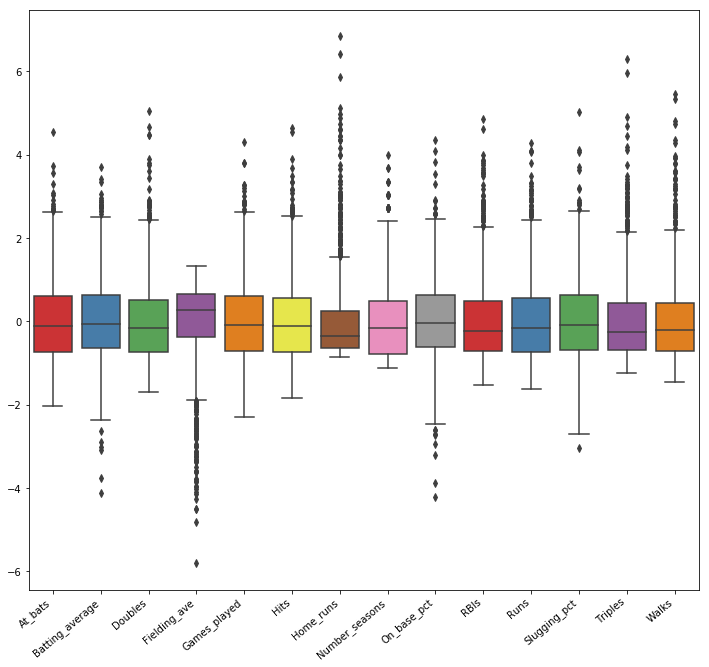

[ 6.  8. 10. 33.  8. 10. 31. 13.  8. 16. 14.  8. 21. 23.]


D:\Programfiles\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:224: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
D:\Programfiles\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:418: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


[ 6.  8. 10. 33.  8. 10. 31. 13.  8. 16. 14.  8. 21. 23.]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [7]:
df = pd.read_csv('datasets_csv/baseball.csv') # original dataframe
df_scaled, df_styled, df_outliers, df_pred, outliers_count = identify_outliers_multi(df, target='Hall_of_Fame')
print(outliers_count)
df_styled

## More Outlier Visualization Choices

## Parallel Coordinates Plot

In Parallel Coordinates each data element is represented as a line passing through the coordinate axes at the values of the element for that dimension. Parallel Coordinates is powerful when dealing with high dimensional data and able to find trends, outliers, extremes.<br>
Isolated lines or lines with different slopes than neighbors are normally considered as outliers. But this is not always true. It can be useful to consider the joint configurations represented by each feature. Even though the individual values on each dimension may seem typical, it can still be an outlier.<br>
Weakness: line based, scalability: suitable for hundreds of items.

In [35]:
def visualize_outliers_parallel_coordinates(df_scaled, df_pred):
    from pandas.plotting import parallel_coordinates
    
    df_final = pd.concat([df_scaled, df_pred], axis=1)
    # print(df_final.head())
    fig = plt.figure(figsize=(12, 10))
    title = fig.suptitle("Parallel Coordinates", fontsize=18)
    fig.subplots_adjust(top=0.93, wspace=0)
    pc = parallel_coordinates(df_final, 'pred', color=('firebrick','skyblue'))
    pc.set_xticklabels(pc.get_xticklabels(), rotation=40, ha="right")
    _=plt.legend(['Anomaly', 'Normal'])
    plt.show()

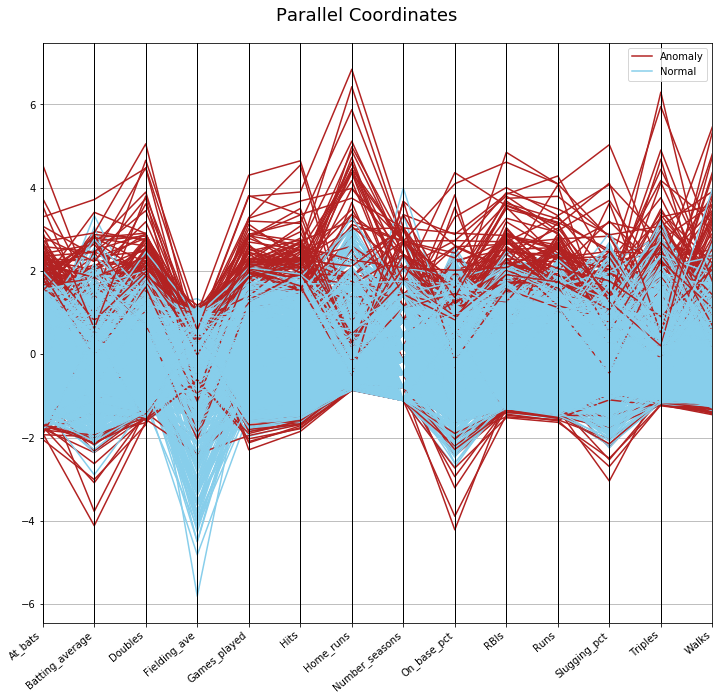

In [36]:
visualize_outliers_parallel_coordinates(df_scaled, df_pred)

## Radar Chart

A radar chart is a graphical method of displaying multivariate data in the form of a two-dimensional chart of three or more quantitative variables represented on axes starting from the same point. The relative position and angle of the axes is typically uninformative.
It is equivalent to a parallel coordinates plot in polar coordinates.

In [37]:
def visualize_outliers_radar_chart(df_scaled, df_pred):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111, polar=True)   # Set polar axis
    labels = df_scaled.columns.values
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False) # Set the angle
    # close the plot
    angles = np.concatenate((angles,[angles[0]]))  # Closed
    for i in range(len(df_scaled)):
        stats = df_scaled.loc[i,labels].values
        stats = np.concatenate((stats,[stats[0]]))  # Closed
        if df_pred.loc[i].values == -1:
            ax.plot(angles, stats, linewidth=1, color='firebrick')  # Draw the anomalies as red
        else:
            ax.plot(angles, stats, linewidth=1, color='skyblue')  # Draw the normal as blue
    ax.set_thetagrids(angles * 180/np.pi, labels)  # Set the label for each axis
    ax.tick_params(direction='out', pad=40)
    plt.show()

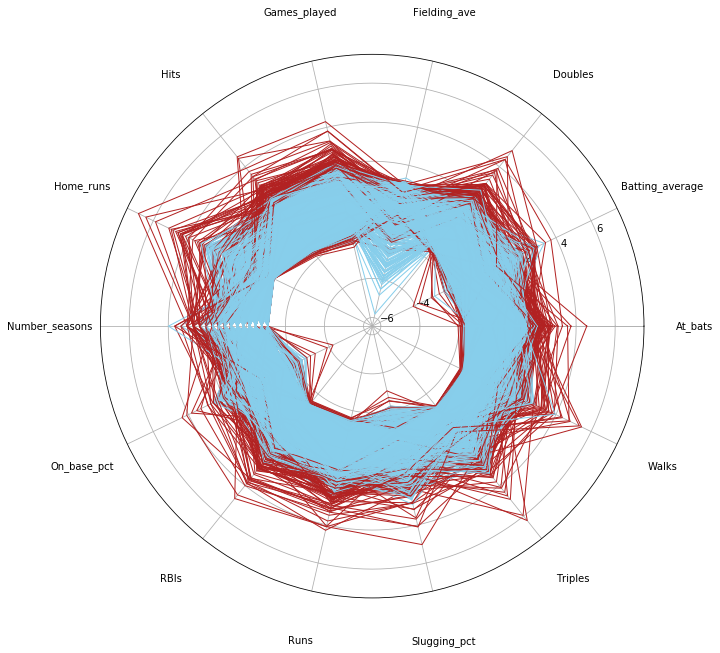

In [40]:
visualize_outliers_radar_chart(df_scaled, df_pred)

## Scatter Plot

We select out the two features most likely to have outliers and show them in a scatter plot.

In [72]:
def visualize_outliers_scatter(df, df_pred, target='Target'):
    """
    Select out the two features most likely to have outliers
    and show them in a scatter plot
    """
    df_exclude_target = df[df.columns.difference([target])] # exclude target from data
    df_numeric = df_exclude_target.select_dtypes(include=[np.number]) # keep only numerical type features
 

    outliers_count = np.zeros(len(df_numeric.columns)) # number of outliers of each feature
    dict_outliers = {}
    flag = False
    df_union = pd.DataFrame()
    for i, col in enumerate(df_numeric.columns):
    #         if(df_numeric[col].dtype in [np.number]): # bug! to be figured out 
        if(df_numeric[col].dtype == np.float64 or df_numeric[col].dtype == np.int64): 
            # first detect outliers in each column
            # keep only the ones that are out of +3 to -3 standard deviations in the column 'Data'.
            dict_outliers[col] = df_numeric[~(np.abs(df_numeric[col]-df_numeric[col].mean())<(3*df_numeric[col].std()))] # ~ means the other way around
            # combine all the rows containing outliers in one feature
            df_union = df_union.combine_first(dict_outliers[col])
    #             print(dict_outliers[col])
            if len(dict_outliers[col]) != 0:
                outliers_count[i] = len(dict_outliers[col])

#     print(outliers_count)

    # get the index of the two features most likely to have outliers
    index_max2 = outliers_count.argsort()[-2:][::-1] # [::-1] reverse

    df_max2=df_numeric.iloc[:,index_max2]
#     print(df_max2.head())

    # draw scatter plot
    df_max2_anomaly=df_max2.loc[df_pred['pred'] == -1]
    df_max2_normal=df_max2.loc[df_pred['pred'] == 1]
    graph = sns.jointplot(x = df_max2[df_max2.columns.values[0]], 
                          y = df_max2[df_max2.columns.values[1]], 
                          color = 'skyblue', 
                          size = 10,
                          space = 0,
                          s = 5)
    graph.x = df_max2_anomaly[df_max2.columns.values[0]]
    graph.y = df_max2_anomaly[df_max2.columns.values[1]]
    graph.plot_joint(plt.scatter,c='firebrick', s=5)
    plt.show()


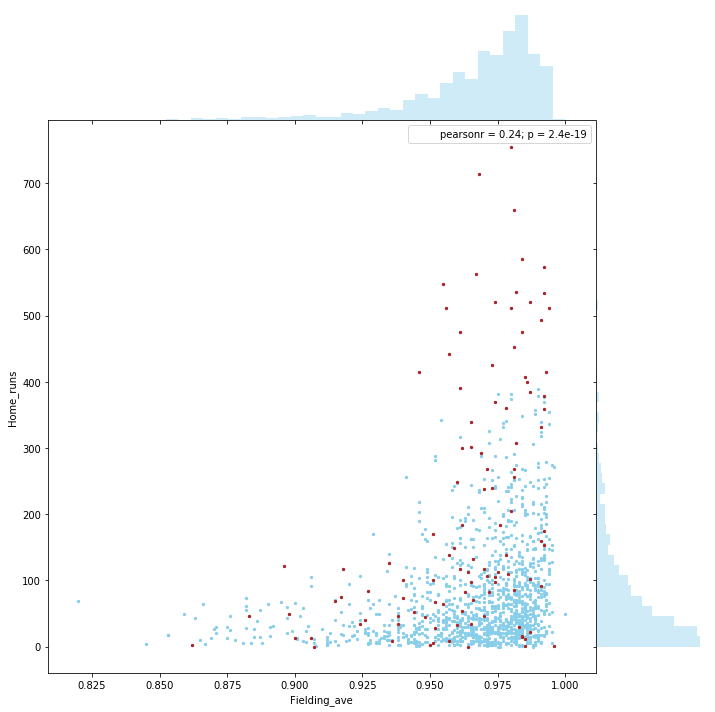

In [73]:
visualize_outliers_scatter(df, df_pred, target='Hall_of_Fame')

## Experiment

In [8]:
df = pd.read_csv('datasets_csv/satellite.csv') # original dataframe
# print(df)
target='Target'
df_exclude_target = df[df.columns.difference([target])] # exclude target from data
df_numeric = df_exclude_target.select_dtypes(include=[np.number]) # keep only numerical type features
X = np.asarray(df_numeric)
# to be extended later, for now isolation forest
clf = IsolationForest()
clf.fit(X)
anomaly_score = clf.decision_function(X) # p_pred: The anomaly score of the input samples. The lower, The more abnormal.


D:\Programfiles\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:214: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
D:\Programfiles\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:224: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


In [9]:
anomaly_score = pd.DataFrame(anomaly_score, columns=['anomaly_score'])
df_with_anomaly_score = pd.concat([df, anomaly_score], axis=1)
df_with_anomaly_score
df_sorted = df_with_anomaly_score.sort_values(by='anomaly_score')
df_sorted

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V29,V30,V31,V32,V33,V34,V35,V36,Target,anomaly_score
27,43,31,139,143,43,31,133,139,46,31,...,46,29,133,151,46,29,138,147,'Anomaly',-0.226809
7,44,31,125,135,47,31,131,135,44,34,...,44,34,139,146,44,32,134,141,'Anomaly',-0.226478
45,44,32,139,141,44,34,139,146,44,29,...,42,32,130,146,42,34,130,142,'Anomaly',-0.224352
20,43,32,138,144,46,32,138,144,46,32,...,44,34,129,143,44,31,124,143,'Anomaly',-0.222455
4,44,34,129,140,44,34,124,136,44,34,...,43,31,128,135,43,29,128,132,'Anomaly',-0.215619
42,44,34,124,136,44,34,119,133,53,56,...,43,31,128,132,46,34,118,132,'Anomaly',-0.213823
60,44,29,115,124,44,29,106,113,44,31,...,41,27,134,137,41,27,123,129,'Anomaly',-0.211913
0,46,40,119,139,42,30,135,157,42,30,...,50,46,111,116,44,31,131,142,'Anomaly',-0.206823
17,42,32,119,127,42,34,110,120,46,34,...,47,31,125,128,47,31,120,124,'Anomaly',-0.200921
54,46,32,127,133,46,32,122,125,46,34,...,42,34,119,129,44,34,114,129,'Anomaly',-0.195273


In [39]:
cm = sns.diverging_palette(10, 220, sep=80, n=7, as_cmap=True)
# cm = sns.dark_palette("springgreen", as_cmap=True)
df_sorted.style.background_gradient(cmap=cm, low=-1, high=1, subset=['anomaly_score'])


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [78]:
import openml as oml
data = oml.datasets.get_dataset(41) # 41
Xy = data.get_data() 
Xy.shape

(214, 10)

In [79]:
df = pd.DataFrame(Xy)

In [95]:
def color_negative_red(value):
    """
    Colors elements in a dateframe green if positive and red if negative. 
    Does not color NaN values.
    """

    if value < 0:
        color = 'firebrick'
    elif value > 0:
        color = 'skyblue'
    else:
        color = 'black'
    return 'color: %s' % color

def highlight_extreme_outliers(value):
    '''
    highlight the extreme in a Series yellow.
    '''
    is_extreme = value < -0.1
    return ['background-color: yellow' if v else '' for v in is_extreme]


def highlight_outlier(data):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_outlier = ~(np.abs(data - data.mean()) < (3 * data.std()))
    return ['background-color: yellow' if v else '' for v in is_outlier]

In [96]:
def identify_outliers(df, variable=None, groupby=None, detailed=False):
    """
    Identify outliers in multi dimension for openml dataset where dataset has already been parsed
    """

#     df_exclude_target = df[df.columns.difference([target])] # exclude target from data
    df_exclude_target = df.iloc[:,:-1]
    df_numeric = df_exclude_target.select_dtypes(include=[np.number]) # keep only numeric type features
    total_length = len(df_numeric) # total length of the dataframe, used for computing contamination later
#     print(total_length)
    
    outliers_count = np.zeros(len(df_numeric.columns)) # number of outliers of each feature
    dict_outliers = {}
    flag = False
    df_union = pd.DataFrame()
    for i, col in enumerate(df_numeric.columns):
#         if(df_numeric[col].dtype in [np.number]): # bug! to be figured out 

        # first detect outliers in each column
        # keep only the ones that are out of +3 to -3 standard deviations in the column 'Data'.
        dict_outliers[col] = df_numeric[~(np.abs(df_numeric[col]-df_numeric[col].mean())<(3*df_numeric[col].std()))] # ~ means the other way around
        # combine all the rows containing outliers in one feature
        df_union = df_union.combine_first(dict_outliers[col])
#             print(dict_outliers[col])
        if len(dict_outliers[col]) != 0:
            outliers_count[i] = len(dict_outliers[col])
            flag = True
            if detailed:                    
                print("There are {} outliers in variable {}".format(len(dict_outliers[col]), col))
                print(dict_outliers[col][col])
                print("")
        else:
            if detailed:
                print("No outliers are detected in variable {}".format(col))
                print("")
    
    # boxplot: show outliers in each feature
    # feature scaling
    ss = StandardScaler()
    df_scaled = ss.fit_transform(df_numeric)
    df_scaled = pd.DataFrame(df_scaled, columns=df_numeric.columns)
    df_scaled.head()
    # draw box plot for numeric variables
    fig = plt.figure(figsize=(12, 10))
    fig.subplots_adjust(top=0.93, wspace=0)
    ax = sns.boxplot(data=df_scaled, palette="Set1")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.show()
    
    # Two options to estimate the propotion of outliers
    # One is to take the number of outliers in the feature containing most outliers
    # The other is to take the length of the union of rows containing outliers in any feature
    print(outliers_count)
#     print(df_union)
#     max_outliers = max(outliers_count)
    max_outliers = len(df_union) 
#     print("max outliers number is {}".format(max_outliers))
#     if flag:
#         print("Outliers detected")
#         print("")
#     else:
#         print("No outliers detected")
#         print("")
#     plt.show()
    contamination = max_outliers / total_length
    X = np.asarray(df_numeric)
    # to be extended later, for now isolation forest
    clf = IsolationForest(contamination = contamination)
    clf.fit(X)
    y_pred = clf.predict(X)
#     print(y_pred)
    outlier_index, = np.where(y_pred == -1)
    df_outliers = df_numeric.iloc[outlier_index.tolist()]
#     print(outlier_index)
    anomaly_score = clf.decision_function(X) # p_pred: The anomaly score of the input samples. The lower, The more abnormal.
    anomaly_score = pd.DataFrame(anomaly_score, columns=['anomaly_score'])
    df_with_anomaly_score = pd.concat([df, anomaly_score], axis=1)
    df_with_anomaly_score
    df_sorted = df_with_anomaly_score.sort_values(by='anomaly_score')
    cm = sns.diverging_palette(10, 220, sep=80, n=7, as_cmap=True)
    df_styled = df_sorted.style.background_gradient(cmap=cm, subset=['anomaly_score']).apply(highlight_outlier, subset=df_sorted.columns[:-1])
#     print("*********************************************")
#     print("Outliers detected in multi dimensional space:")
#     print("*********************************************")

#     print(df_numeric.iloc[outlier_index.tolist()])
    df_pred = pd.DataFrame(y_pred, columns=['pred'])
    return df_scaled, df_styled, df_outliers, df_pred, outliers_count

D:\Programfiles\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Programfiles\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
D:\Programfiles\Anaconda3\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


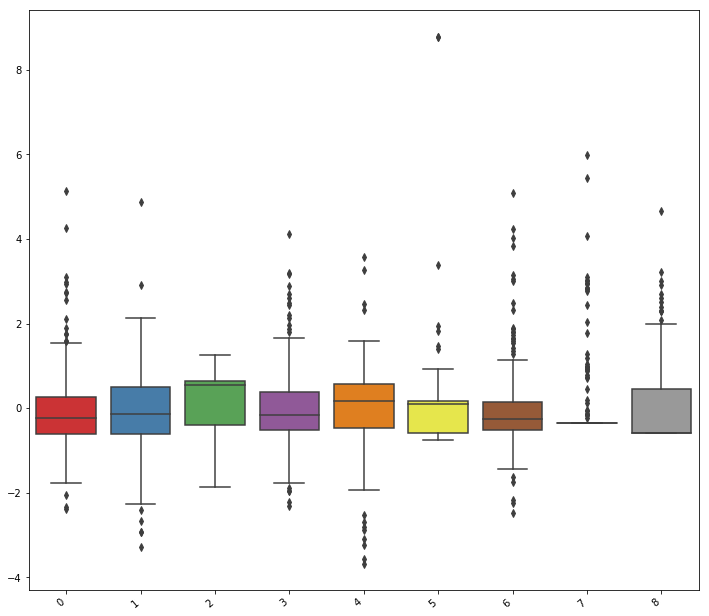

[3. 2. 0. 3. 6. 3. 7. 6. 3.]


D:\Programfiles\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:224: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
D:\Programfiles\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:418: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [97]:
df_scaled, df_styled, df_outliers, df_pred, outliers_count = identify_outliers(df)

In [98]:
df_styled

,0,1,2,3,4,5,6,7,8,9,anomaly_score
68,1.53125,10.73,0,2.1,69.81,0.58,13.3,3.15,0.28,1,-0.182281
46,1.51514,14.01,2.68,3.5,69.89,1.68,5.87,2.2,0,4,-0.135589
4,1.53393,12.3,0,1,70.16,0.12,16.19,0,0.24,1,-0.123574
105,1.51316,13.02,0,3.04,70.48,6.21,6.96,0,0,4,-0.119413
163,1.51321,13,0,3.02,70.7,6.21,6.93,0,0,4,-0.117612
32,1.51115,17.38,0,0.34,75.41,0,6.65,0,0,5,-0.0969372
24,1.52058,12.85,1.61,2.17,72.18,0.76,9.7,0.24,0.51,4,-0.0899955
102,1.52365,15.79,1.83,1.31,70.43,0.31,8.61,1.68,0,6,-0.0823851
173,1.51831,14.39,0,1.82,72.86,1.41,6.47,2.88,0,6,-0.0820739
150,1.51131,13.69,3.2,1.81,72.81,1.76,5.43,1.19,0,6,-0.0762463


In [37]:
df_outliers

,0,1,2,3,4,5,6,7,8
4,1.53393,12.300000,0.00,1.00,70.160004,0.12,16.190001,0.00,0.24
21,1.52475,11.450000,0.00,1.88,72.190002,0.81,13.240000,0.00,0.34
24,1.52058,12.850000,1.61,2.17,72.180000,0.76,9.700000,0.24,0.51
32,1.51115,17.379999,0.00,0.34,75.410004,0.00,6.650000,0.00,0.00
46,1.51514,14.010000,2.68,3.50,69.889999,1.68,5.870000,2.20,0.00
56,1.52247,14.860000,2.20,2.06,70.260002,0.76,9.760000,0.00,0.00
67,1.52211,14.190000,3.78,0.91,71.360001,0.23,9.140000,0.00,0.37
68,1.53125,10.730000,0.00,2.10,69.809998,0.58,13.300000,3.15,0.28
86,1.52777,12.640000,0.00,0.67,72.019997,0.06,14.400000,0.00,0.00
102,1.52365,15.790000,1.83,1.31,70.430000,0.31,8.610000,1.68,0.00


In [62]:
df.style.apply(highlight_max, subset=df.columns)

,0,1,2,3,4,5,6,7,8,9
0,1.51793,12.79,3.5,1.12,73.03,0.64,8.77,0,0,0
1,1.51643,12.16,3.52,1.35,72.89,0.57,8.53,0,0,2
2,1.51793,13.21,3.48,1.41,72.64,0.59,8.43,0,0,0
3,1.51299,14.4,1.74,1.54,74.55,0,7.59,0,0,5
4,1.53393,12.3,0,1,70.16,0.12,16.19,0,0.24,1
5,1.51655,12.75,2.85,1.44,73.27,0.57,8.79,0.11,0.22,1
6,1.51779,13.64,3.65,0.65,73,0.06,8.93,0,0,2
7,1.51837,13.14,2.84,1.28,72.85,0.55,9.07,0,0,0
8,1.51545,14.14,0,2.68,73.39,0.08,9.07,0.61,0.05,6
9,1.51789,13.19,3.9,1.3,72.33,0.55,8.44,0,0.28,1


In [91]:
print(df.columns[:-1])

RangeIndex(start=0, stop=9, step=1)
